### Importing Libraries

In [0]:
import tensorflow as tf
tf.__version__

'2.2.0-rc4'

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [0]:
import os
import random
import zipfile
from shutil import copyfile

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

### Using API to download the dataset and Creating Traing and Testing Data

In [0]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2020-05-06 08:01:12--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.1.244.151, 2600:1406:1400:580::e59, 2600:1406:1400:58d::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.1.244.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M  65.8MB/s    in 10s     

2020-05-06 08:01:22 (78.4 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [0]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


In [0]:
to_create = [
    '/tmp/cats-v-dogs',
    '/tmp/cats-v-dogs/training',
    '/tmp/cats-v-dogs/testing',
    '/tmp/cats-v-dogs/training/cats',
    '/tmp/cats-v-dogs/training/dogs',
    '/tmp/cats-v-dogs/testing/cats',
    '/tmp/cats-v-dogs/testing/dogs'
]

for directory in to_create:
    try:
        os.mkdir(directory)
        print(directory, 'created')
    except:
        print(directory, 'failed')

/tmp/cats-v-dogs created
/tmp/cats-v-dogs/training created
/tmp/cats-v-dogs/testing created
/tmp/cats-v-dogs/training/cats created
/tmp/cats-v-dogs/training/dogs created
/tmp/cats-v-dogs/testing/cats created
/tmp/cats-v-dogs/testing/dogs created


In [0]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    all_files = []
    
    for file_name in os.listdir(SOURCE):
        file_path = SOURCE + file_name

        if os.path.getsize(file_path):
            all_files.append(file_name)
        else:
            print('{} is zero length, so ignoring'.format(file_name))
    
    n_files = len(all_files)
    split_point = int(n_files * SPLIT_SIZE)
    
    shuffled = random.sample(all_files, n_files)
    
    train_set = shuffled[:split_point]
    test_set = shuffled[split_point:]
    
    for file_name in train_set:
        copyfile(SOURCE + file_name, TRAINING + file_name)
        
    for file_name in test_set:
        copyfile(SOURCE + file_name, TESTING + file_name)

CAT_SOURCE_DIR = r"/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = r"/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = r"/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = r"/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = r"/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = r"/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring
11702.jpg is zero length, so ignoring


In [0]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


### Building CNN Model

In [0]:
model=Sequential()

In [0]:
model.add(Convolution2D(32,(3,3),input_shape=(150,150,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2),padding='valid'))
model.add(Dropout(0.4))
model.add(Convolution2D(32,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2),padding='valid'))
model.add(Dropout(0.4))
model.add(Convolution2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2),padding='valid'))
model.add(Flatten())
model.add(Dense(units=512,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))

In [0]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)       

### Image Augmentation for better accuracy

Helps to enrich our data set with less number of images to prevent overfitting.

In [0]:
train_datagen = ImageDataGenerator(
        rescale=1./255)

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
training_set = train_datagen.flow_from_directory(
        '/tmp/cats-v-dogs/training',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

Found 22498 images belonging to 2 classes.


In [0]:
testing_set = test_datagen.flow_from_directory(
        '/tmp/cats-v-dogs/testing',
        target_size=(150,150),
        batch_size=64,
        class_mode='binary')

Found 2500 images belonging to 2 classes.


In [0]:
nb_train_samples=22498
nb_validation_samples=2500
batch_size=64

In [0]:
filepath = os.path.join("./cat_dog/model_v{epoch}.hdf5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                                             monitor='val_accuracy',
                                             verbose=1,
                                             save_best_only=True,
                                             mode='max')
callbacks = [checkpoint]

In [0]:
history=model.fit_generator(
        training_set,
        steps_per_epoch=nb_train_samples// batch_size,
        epochs=10,
        validation_data=testing_set,
        callbacks=callbacks,
        validation_steps=nb_validation_samples // batch_size
        )

Epoch 1/10
 89/351 [======>.......................] - ETA: 47s - loss: 0.9140 - accuracy: 0.5323

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

351/351 [==============================] - ETA: 0s - loss: 0.7064 - accuracy: 0.6003
Epoch 00001: val_accuracy improved from -inf to 0.61498, saving model to ./cat_dog/model_v1.hdf5
351/351 [==============================] - 72s 204ms/step - loss: 0.7064 - accuracy: 0.6003 - val_loss: 0.6376 - val_accuracy: 0.6150
Epoch 2/10
351/351 [==============================] - ETA: 0s - loss: 0.5562 - accuracy: 0.7101
Epoch 00002: val_accuracy improved from 0.61498 to 0.71835, saving model to ./cat_dog/model_v2.hdf5
351/351 [==============================] - 72s 204ms/step - loss: 0.5562 - accuracy: 0.7101 - val_loss: 0.5616 - val_accuracy: 0.7183
Epoch 3/10
351/351 [==============================] - ETA: 0s - loss: 0.5125 - accuracy: 0.7440
Epoch 00003: val_accuracy improved from 0.71835 to 0.75000, saving model to ./cat_dog/model_v3.hdf5
351/351 [==============================] - 72s 204ms/step - loss: 0.5125 - accuracy: 0.7440 - val_loss: 0.5250 - val_accuracy: 0.7500
Epoch 4/10
351/351 [====

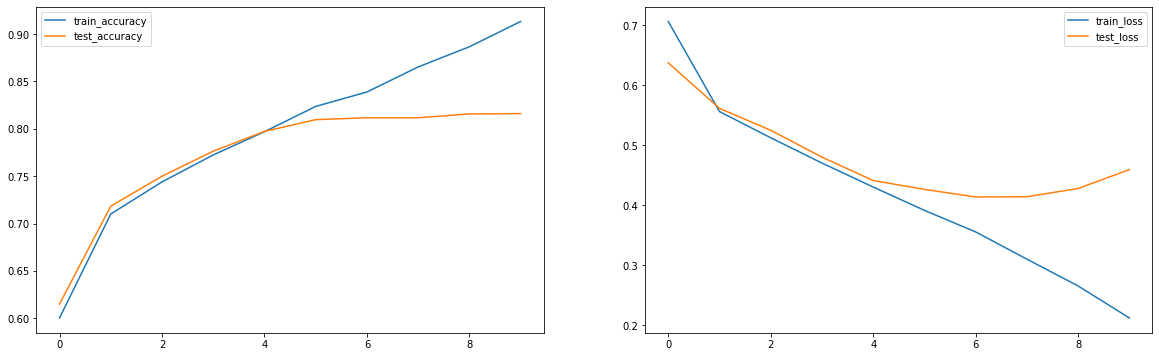

In [0]:
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(20,6))
ax1.plot(history.history['accuracy'],label='train_accuracy')
ax1.plot(history.history['val_accuracy'],label='test_accuracy')
ax1.legend()
ax2.plot(history.history['loss'],label='train_loss')
ax2.plot(history.history['val_loss'],label='test_loss')
ax2.legend()
plt.show()

### Testing Using New Images

In [0]:
training_set.class_indices

{'cats': 0, 'dogs': 1}

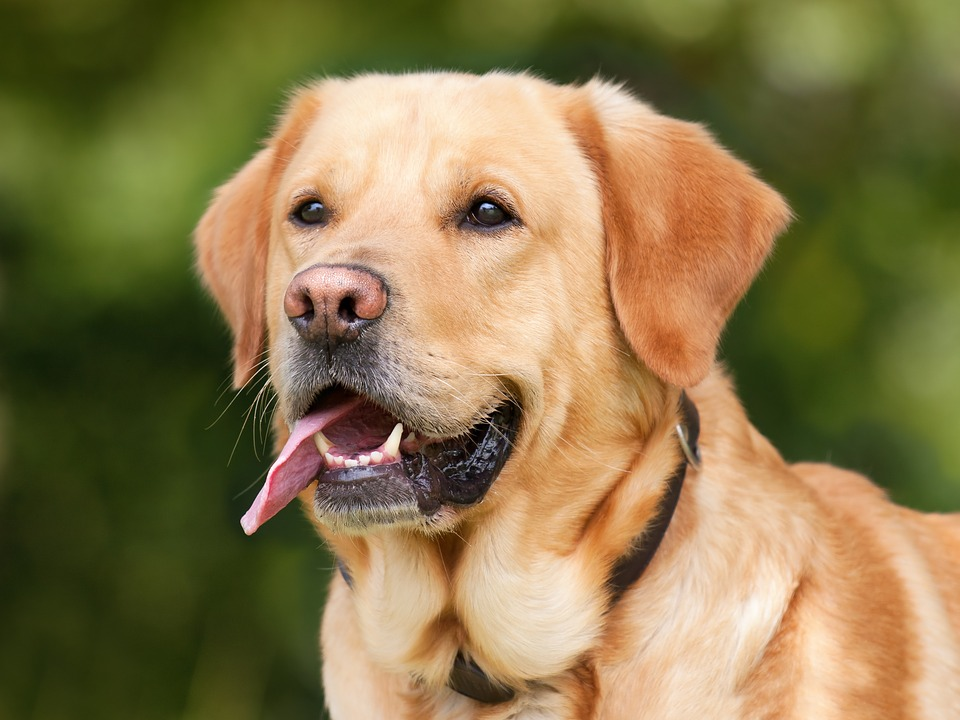

In [0]:
from IPython.display import Image
Image(filename='/content/drive/My Drive/CNN/Cat_Dog_Dataset/single_prediction/cat_or_dog_1.jpg',width=250,height=250)

In [0]:
test_image=image.load_img('/content/drive/My Drive/CNN/Cat_Dog_Dataset/single_prediction/cat_or_dog_1.jpg',target_size=(150,150))

In [0]:
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

In [0]:
classifier = load_model('/content/cat_dog/model_v10.hdf5')

In [0]:
result = classifier.predict(test_image)
if result[0][0] == 1:
    prediction = 'dog'
else:
    prediction = 'cat'
prediction

'dog'

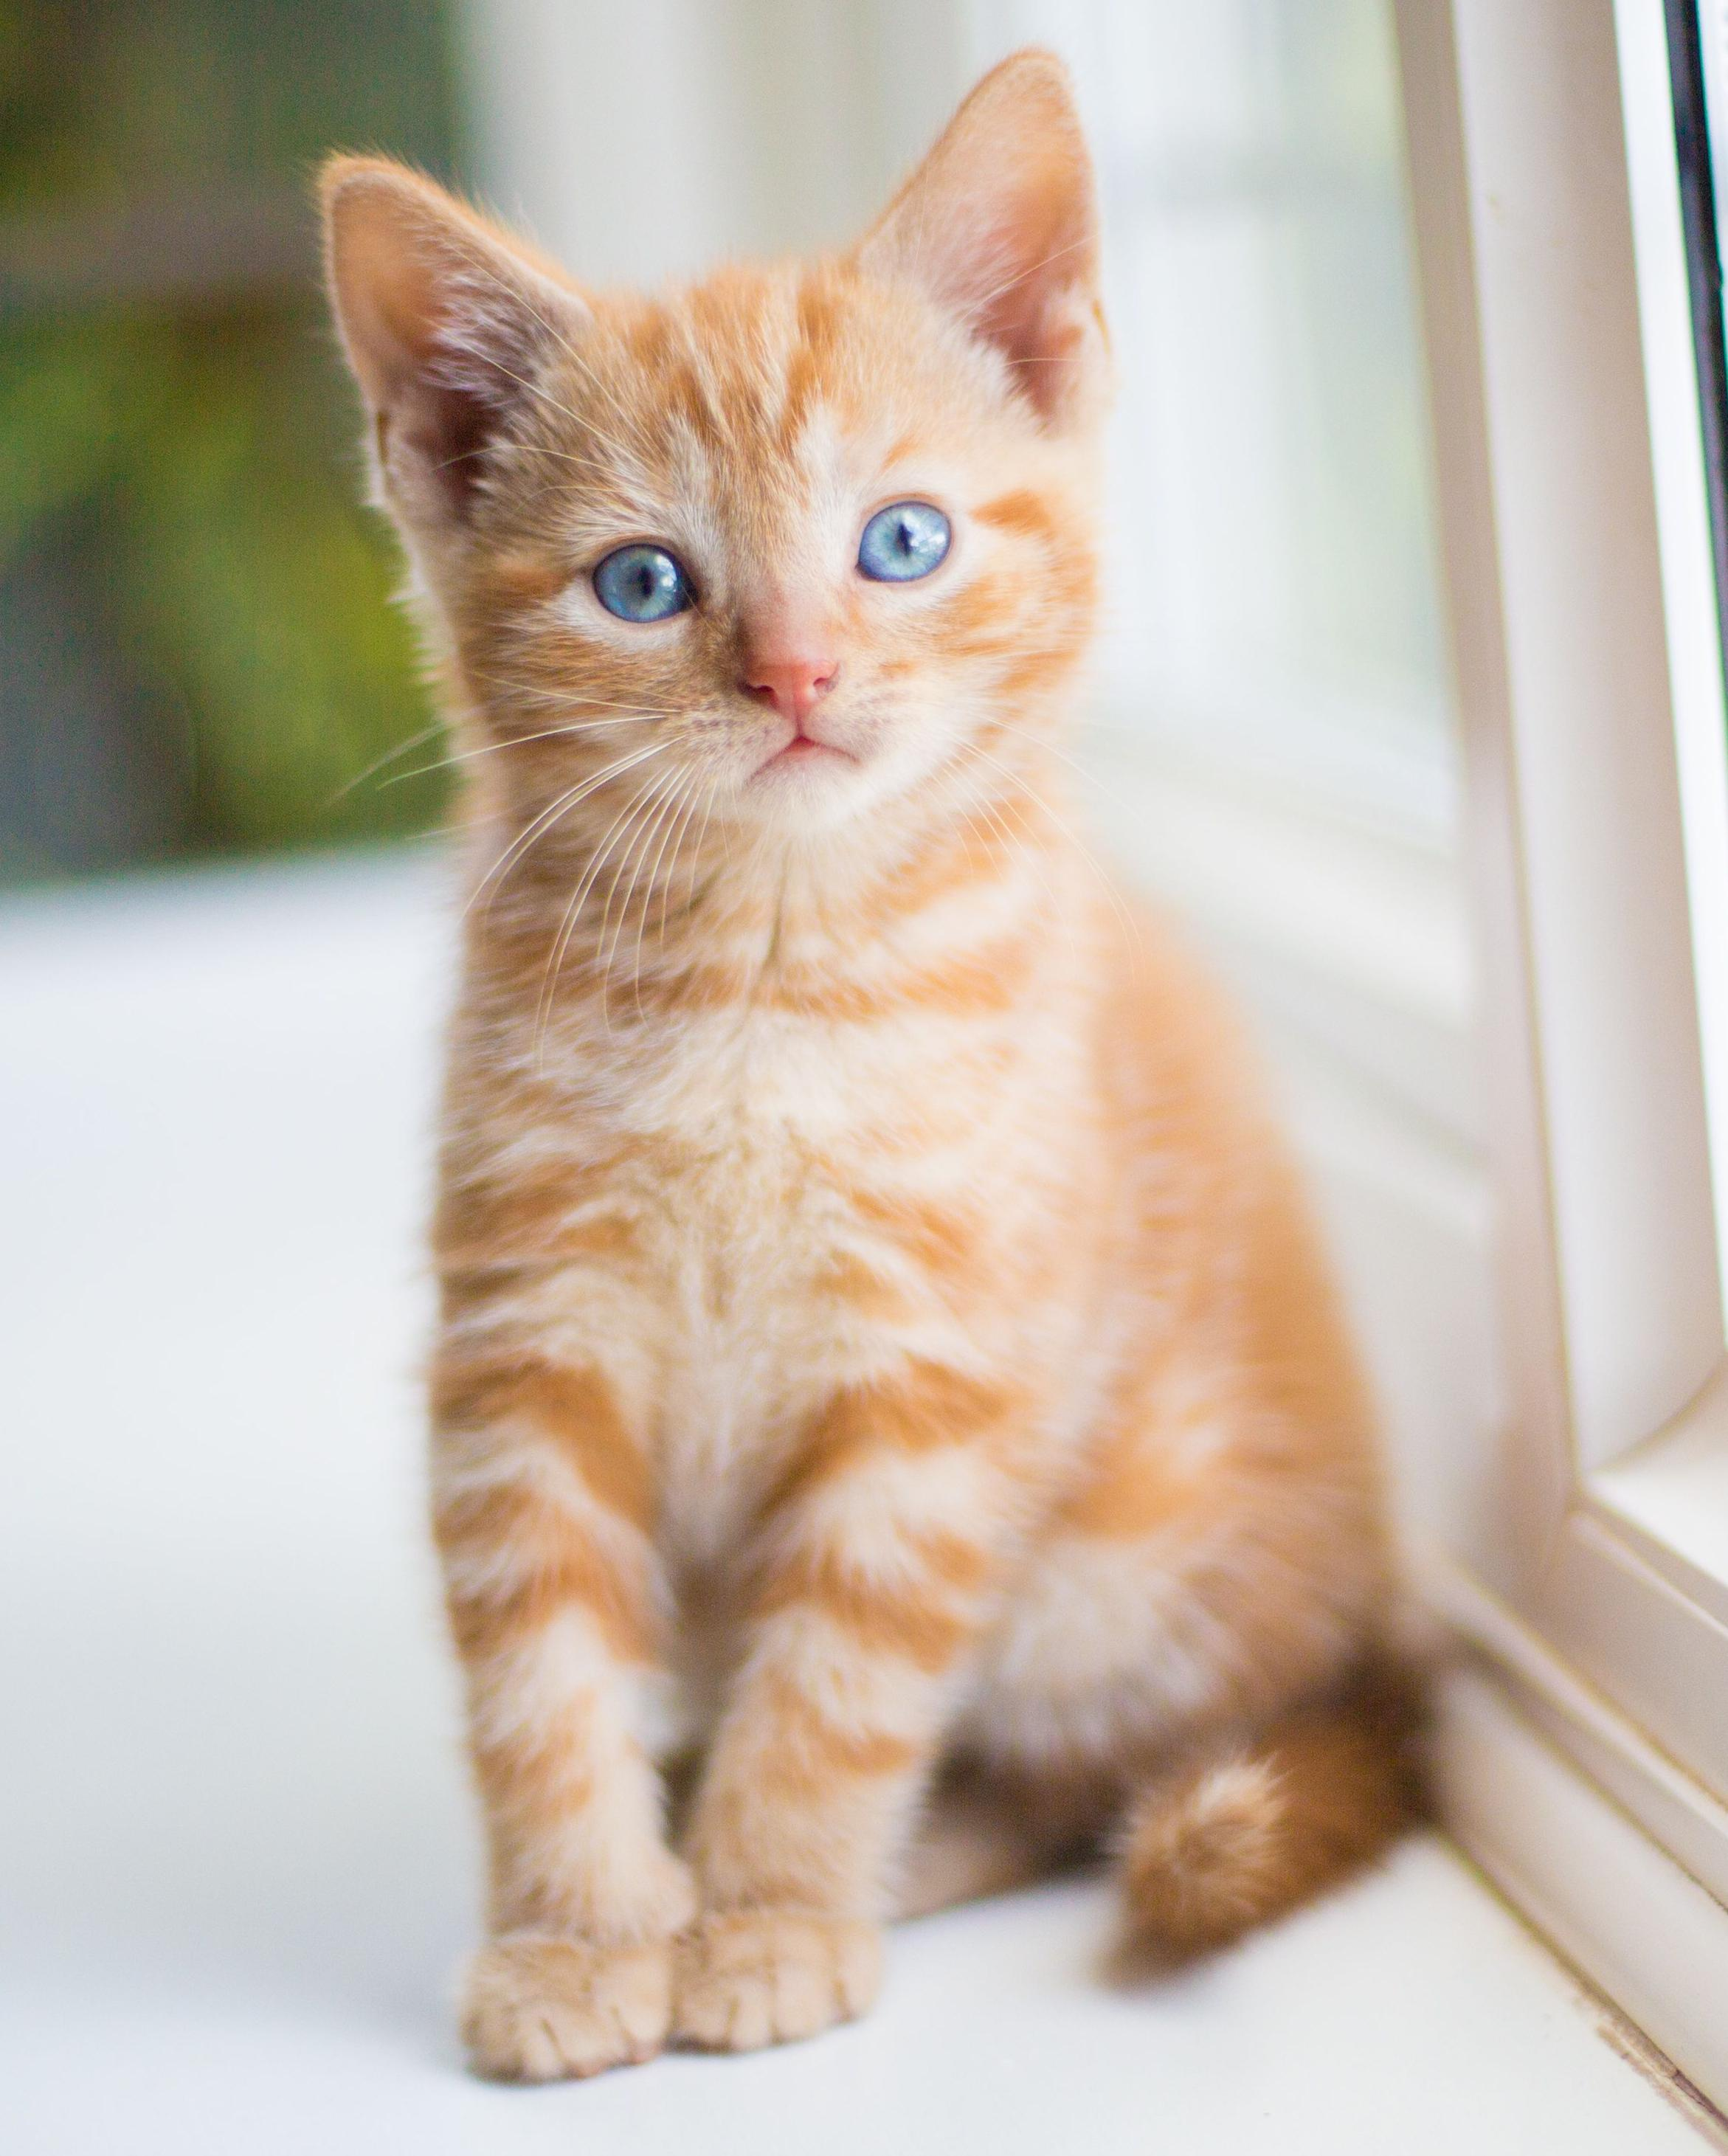

In [0]:
from IPython.display import Image
Image(filename='/content/drive/My Drive/CNN/Cat_Dog_Dataset/single_prediction/cat_or_dog_3.jpg',width=250,height=250)

In [0]:
test_image=image.load_img('/content/drive/My Drive/CNN/Cat_Dog_Dataset/single_prediction/cat_or_dog_3.jpg',target_size=(150,150))

In [0]:
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

In [0]:
result = classifier.predict(test_image)
if result[0][0] == 1:
    prediction = 'dog'
else:
    prediction = 'cat'
prediction

'cat'